<a href="https://colab.research.google.com/github/rballachay/homework/blob/main/COMP579/COMP579_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install Gym

In [4]:
!pip install gymnasium[mujoco]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Mount to Google Drive

In [1]:
from google.colab import drive

drive.mount('/content/drive/')

CACHE_DIR = 'drive/MyDrive/COMP579'

Mounted at /content/drive/


# PPO Training
### Copy from https://github.com/nikhilbarhate99/PPO-PyTorch

In [ ]:
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
from torch.distributions import Categorical
import gymnasium as gym
from datetime import datetime
import pandas as pd
import numpy as np

################################## set device ##################################
print("============================================================================================")
# set device to cpu or cuda
device = torch.device('cpu')
if(torch.cuda.is_available()): 
    device = torch.device('cuda:0') 
    torch.cuda.empty_cache()
    print("Device set to : " + str(torch.cuda.get_device_name(device)))
else:
    print("Device set to : cpu")
print("============================================================================================")


################################## PPO Policy ##################################
class RolloutBuffer:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.state_values = []
        self.is_terminals = []
    
    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.state_values[:]
        del self.is_terminals[:]


class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, has_continuous_action_space, action_std_init):
        super(ActorCritic, self).__init__()

        self.has_continuous_action_space = has_continuous_action_space
        
        if has_continuous_action_space:
            self.action_dim = action_dim
            self.action_var = torch.full((action_dim,), action_std_init * action_std_init).to(device)
        # actor
        if has_continuous_action_space :
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Tanh()
                        )
        else:
            self.actor = nn.Sequential(
                            nn.Linear(state_dim, 64),
                            nn.Tanh(),
                            nn.Linear(64, 64),
                            nn.Tanh(),
                            nn.Linear(64, action_dim),
                            nn.Softmax(dim=-1)
                        )
        # critic
        self.critic = nn.Sequential(
                        nn.Linear(state_dim, 64),
                        nn.Tanh(),
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                    )
        
    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_var = torch.full((self.action_dim,), new_action_std * new_action_std).to(device)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling ActorCritic::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def forward(self):
        raise NotImplementedError
    
    def act(self, state):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            cov_mat = torch.diag(self.action_var).unsqueeze(dim=0)
            dist = MultivariateNormal(action_mean, cov_mat)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)

        action = dist.sample()
        action_logprob = dist.log_prob(action)
        state_val = self.critic(state)

        return action.detach(), action_logprob.detach(), state_val.detach()
    
    def evaluate(self, state, action):

        if self.has_continuous_action_space:
            action_mean = self.actor(state)
            
            action_var = self.action_var.expand_as(action_mean)
            cov_mat = torch.diag_embed(action_var).to(device)
            dist = MultivariateNormal(action_mean, cov_mat)
            
            # For Single Action Environments.
            if self.action_dim == 1:
                action = action.reshape(-1, self.action_dim)
        else:
            action_probs = self.actor(state)
            dist = Categorical(action_probs)
        action_logprobs = dist.log_prob(action)
        dist_entropy = dist.entropy()
        state_values = self.critic(state)
        
        return action_logprobs, state_values, dist_entropy


class PPO:
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std_init=0.6):

        self.has_continuous_action_space = has_continuous_action_space

        if has_continuous_action_space:
            self.action_std = action_std_init

        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        
        self.buffer = RolloutBuffer()

        self.policy = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.optimizer = torch.optim.Adam([
                        {'params': self.policy.actor.parameters(), 'lr': lr_actor},
                        {'params': self.policy.critic.parameters(), 'lr': lr_critic}
                    ])

        self.policy_old = ActorCritic(state_dim, action_dim, has_continuous_action_space, action_std_init).to(device)
        self.policy_old.load_state_dict(self.policy.state_dict())
        
        self.MseLoss = nn.MSELoss()

    def set_action_std(self, new_action_std):
        if self.has_continuous_action_space:
            self.action_std = new_action_std
            self.policy.set_action_std(new_action_std)
            self.policy_old.set_action_std(new_action_std)
        else:
            print("--------------------------------------------------------------------------------------------")
            print("WARNING : Calling PPO::set_action_std() on discrete action space policy")
            print("--------------------------------------------------------------------------------------------")

    def decay_action_std(self, action_std_decay_rate, min_action_std):
        #print("--------------------------------------------------------------------------------------------")
        if self.has_continuous_action_space:
            self.action_std = self.action_std - action_std_decay_rate
            self.action_std = round(self.action_std, 4)
            if (self.action_std <= min_action_std):
                self.action_std = min_action_std
                #print("setting actor output action_std to min_action_std : ", self.action_std)
            else:
                #print("setting actor output action_std to : ", self.action_std)
                pass
            self.set_action_std(self.action_std)

        else:
            print("WARNING : Calling PPO::decay_action_std() on discrete action space policy")
        #print("--------------------------------------------------------------------------------------------")

    def select_action(self, state):

        if self.has_continuous_action_space:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)

            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.detach().cpu().numpy().flatten()
        else:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                action, action_logprob, state_val = self.policy_old.act(state)
            
            self.buffer.states.append(state)
            self.buffer.actions.append(action)
            self.buffer.logprobs.append(action_logprob)
            self.buffer.state_values.append(state_val)

            return action.item()

    def update(self):
        # Monte Carlo estimate of returns
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(self.buffer.rewards), reversed(self.buffer.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
            
        # Normalizing the rewards
        rewards = torch.tensor(rewards, dtype=torch.float32).to(device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)

        # convert list to tensor
        old_states = torch.squeeze(torch.stack(self.buffer.states, dim=0)).detach().to(device)
        old_actions = torch.squeeze(torch.stack(self.buffer.actions, dim=0)).detach().to(device)
        old_logprobs = torch.squeeze(torch.stack(self.buffer.logprobs, dim=0)).detach().to(device)
        old_state_values = torch.squeeze(torch.stack(self.buffer.state_values, dim=0)).detach().to(device)

        # calculate advantages
        advantages = rewards.detach() - old_state_values.detach()

        # Optimize policy for K epochs
        for _ in range(self.K_epochs):

            # Evaluating old actions and values
            logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)

            # match state_values tensor dimensions with rewards tensor
            state_values = torch.squeeze(state_values)
            
            # Finding the ratio (pi_theta / pi_theta__old)
            ratios = torch.exp(logprobs - old_logprobs.detach())

            # Finding Surrogate Loss  
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages

            # final loss of clipped objective PPO
            loss = -torch.min(surr1, surr2) + 0.5 * self.MseLoss(state_values, rewards) - 0.01 * dist_entropy
            
            # take gradient step
            self.optimizer.zero_grad()
            loss.mean().backward()
            self.optimizer.step()
            
        # Copy new weights into old policy
        self.policy_old.load_state_dict(self.policy.state_dict())

        # clear buffer
        self.buffer.clear()
    
    def save(self, checkpoint_path):
        torch.save(self.policy_old.state_dict(), checkpoint_path)
   
    def load(self, checkpoint_path):
        self.policy_old.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))
        self.policy.load_state_dict(torch.load(checkpoint_path, map_location=lambda storage, loc: storage))

env_name = "HalfCheetah-v4"
has_continuous_action_space = True

max_ep_len = 1000                   # max timesteps in one episode
max_training_timesteps = int(1e6)   # break training loop if timeteps > max_training_timesteps

print_freq = max_ep_len * 4     # print avg reward in the interval (in num timesteps)

action_std = 0.5
action_std_decay_freq = 10
action_std_decay_rate =  0.05
min_action_std = 0.1

update_timestep = max_ep_len * 4      # update policy every n timesteps
K_epochs = 40               # update policy for K epochs
eps_clip = 0.2              # clip parameter for PPO
gamma = 0.99                # discount factor

lr_actor = 0.0003       # learning rate for actor network
lr_critic = 0.001       # learning rate for critic network

n_reps = 10

print("training environment name : " + env_name)

all_rewards = pd.DataFrame()
for iteration in range(n_reps):
    env = gym.make(env_name)

    _dic = {'timestep':[],'reward':[],'iteration':[]}

    # state space dimension
    state_dim = env.observation_space.shape[0]

    # action space dimension
    if has_continuous_action_space:
        action_dim = env.action_space.shape[0]
    else:
        action_dim = env.action_space.n


    #####################################################

    print("============================================================================================")

    ################# training procedure ################

    # initialize a PPO agent
    ppo_agent = PPO(state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip, has_continuous_action_space, action_std)


    # track total training time
    start_time = datetime.now().replace(microsecond=0)
    print("Started training at (GMT) : ", start_time)

    print("============================================================================================")


    # printing and logging variables
    print_running_reward = 0
    print_running_episodes = 0
    time_step = 0
    i_episode = 0


    # training loop
    while time_step <= max_training_timesteps:
        
        state,_ = env.reset()

        current_ep_reward = 0

        for t in range(1, max_ep_len+1):
            # select action with policy
            action = ppo_agent.select_action(state)
            state, reward, done, _,_ = env.step(action)
            
            # saving reward and is_terminals
            ppo_agent.buffer.rewards.append(reward)
            ppo_agent.buffer.is_terminals.append(done)
            
            time_step +=1
            current_ep_reward += reward

            # update PPO agent
            if time_step % update_timestep == 0:
                ppo_agent.update()

            # if continuous action space; then decay action std of ouput action distribution
            if has_continuous_action_space and time_step % action_std_decay_freq == 0:
                ppo_agent.decay_action_std(action_std_decay_rate, min_action_std)

            # printing average reward
            if time_step % print_freq == 0:

                # print average reward till last episode
                print_avg_reward = print_running_reward / print_running_episodes
                print_avg_reward = round(print_avg_reward, 2)

                print("Episode : {} \t\t Timestep : {} \t\t Average Reward : {}".format(i_episode, time_step, print_avg_reward))

                print_running_reward = 0
                print_running_episodes = 0
                
            # break; if the episode is over
            if done:
                break

        _dic['reward'].append(current_ep_reward)    
        _dic['timestep'].append(time_step)
        _dic['iteration'].append(iteration)

        print_running_reward += current_ep_reward
        print_running_episodes += 1

        i_episode += 1

    _buffer = ppo_agent.buffer.rewards.copy()
    _df = pd.DataFrame(_dic)
    all_rewards = all_rewards.append(_df)
    env.close()


all_rewards=all_rewards.reset_index(drop=True)
all_rewards.to_csv(f'{CACHE_DIR}/ppo_training_{n_reps}x{max_training_timesteps}.csv')

# print total training time
print("============================================================================================")
end_time = datetime.now().replace(microsecond=0)
print("Started training at (GMT) : ", start_time)
print("Finished training at (GMT) : ", end_time)
print("Total training time  : ", end_time - start_time)
print("============================================================================================")

Device set to : cpu
training environment name : HalfCheetah-v4
Started training at (GMT) :  2023-04-12 22:59:32
Episode : 3 		 Timestep : 4000 		 Average Reward : -19.9
Episode : 7 		 Timestep : 8000 		 Average Reward : -13.42
Episode : 11 		 Timestep : 12000 		 Average Reward : 0.67
Episode : 15 		 Timestep : 16000 		 Average Reward : 16.64
Episode : 19 		 Timestep : 20000 		 Average Reward : 32.66
Episode : 23 		 Timestep : 24000 		 Average Reward : 52.12
Episode : 27 		 Timestep : 28000 		 Average Reward : 75.56
Episode : 31 		 Timestep : 32000 		 Average Reward : 97.72
Episode : 35 		 Timestep : 36000 		 Average Reward : 112.28
Episode : 39 		 Timestep : 40000 		 Average Reward : 128.03
Episode : 43 		 Timestep : 44000 		 Average Reward : 154.31
Episode : 47 		 Timestep : 48000 		 Average Reward : 163.91
Episode : 51 		 Timestep : 52000 		 Average Reward : 188.04
Episode : 55 		 Timestep : 56000 		 Average Reward : 195.6
Episode : 59 		 Timestep : 60000 		 Average Reward : 216.86
E

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-12 23:22:47
Episode : 3 		 Timestep : 4000 		 Average Reward : -13.39
Episode : 7 		 Timestep : 8000 		 Average Reward : -15.24
Episode : 11 		 Timestep : 12000 		 Average Reward : -7.58
Episode : 15 		 Timestep : 16000 		 Average Reward : -3.48
Episode : 19 		 Timestep : 20000 		 Average Reward : -2.34
Episode : 23 		 Timestep : 24000 		 Average Reward : 10.42
Episode : 27 		 Timestep : 28000 		 Average Reward : 21.2
Episode : 31 		 Timestep : 32000 		 Average Reward : 33.63
Episode : 35 		 Timestep : 36000 		 Average Reward : 52.14
Episode : 39 		 Timestep : 40000 		 Average Reward : 64.31
Episode : 43 		 Timestep : 44000 		 Average Reward : 90.91
Episode : 47 		 Timestep : 48000 		 Average Reward : 107.08
Episode : 51 		 Timestep : 52000 		 Average Reward : 126.98
Episode : 55 		 Timestep : 56000 		 Average Reward : 155.83
Episode : 59 		 Timestep : 60000 		 Average Reward : 174.59
Episode : 63 		 Timestep : 64000 		 Average Reward : 192.84
Episo

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-12 23:46:23
Episode : 3 		 Timestep : 4000 		 Average Reward : -95.16
Episode : 7 		 Timestep : 8000 		 Average Reward : -73.98
Episode : 11 		 Timestep : 12000 		 Average Reward : -53.26
Episode : 15 		 Timestep : 16000 		 Average Reward : -43.63
Episode : 19 		 Timestep : 20000 		 Average Reward : -26.6
Episode : 23 		 Timestep : 24000 		 Average Reward : -11.64
Episode : 27 		 Timestep : 28000 		 Average Reward : -4.91
Episode : 31 		 Timestep : 32000 		 Average Reward : -2.25
Episode : 35 		 Timestep : 36000 		 Average Reward : 13.65
Episode : 39 		 Timestep : 40000 		 Average Reward : 24.71
Episode : 43 		 Timestep : 44000 		 Average Reward : 31.16
Episode : 47 		 Timestep : 48000 		 Average Reward : 39.47
Episode : 51 		 Timestep : 52000 		 Average Reward : 50.65
Episode : 55 		 Timestep : 56000 		 Average Reward : 61.19
Episode : 59 		 Timestep : 60000 		 Average Reward : 71.71
Episode : 63 		 Timestep : 64000 		 Average Reward : 85.76
Episod

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-13 00:10:07
Episode : 3 		 Timestep : 4000 		 Average Reward : -25.36
Episode : 7 		 Timestep : 8000 		 Average Reward : -12.83
Episode : 11 		 Timestep : 12000 		 Average Reward : -6.12
Episode : 15 		 Timestep : 16000 		 Average Reward : -8.77
Episode : 19 		 Timestep : 20000 		 Average Reward : -4.01
Episode : 23 		 Timestep : 24000 		 Average Reward : 3.48
Episode : 27 		 Timestep : 28000 		 Average Reward : 10.9
Episode : 31 		 Timestep : 32000 		 Average Reward : 14.55
Episode : 35 		 Timestep : 36000 		 Average Reward : 16.18
Episode : 39 		 Timestep : 40000 		 Average Reward : 20.16
Episode : 43 		 Timestep : 44000 		 Average Reward : 25.84
Episode : 47 		 Timestep : 48000 		 Average Reward : 28.91
Episode : 51 		 Timestep : 52000 		 Average Reward : 38.04
Episode : 55 		 Timestep : 56000 		 Average Reward : 45.65
Episode : 59 		 Timestep : 60000 		 Average Reward : 50.8
Episode : 63 		 Timestep : 64000 		 Average Reward : 56.12
Episode : 67

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-13 00:33:38
Episode : 3 		 Timestep : 4000 		 Average Reward : -171.44
Episode : 7 		 Timestep : 8000 		 Average Reward : -155.87
Episode : 11 		 Timestep : 12000 		 Average Reward : -120.82
Episode : 15 		 Timestep : 16000 		 Average Reward : -109.79
Episode : 19 		 Timestep : 20000 		 Average Reward : -87.35
Episode : 23 		 Timestep : 24000 		 Average Reward : -68.48
Episode : 27 		 Timestep : 28000 		 Average Reward : -48.65
Episode : 31 		 Timestep : 32000 		 Average Reward : -25.4
Episode : 35 		 Timestep : 36000 		 Average Reward : -5.06
Episode : 39 		 Timestep : 40000 		 Average Reward : 18.86
Episode : 43 		 Timestep : 44000 		 Average Reward : 49.83
Episode : 47 		 Timestep : 48000 		 Average Reward : 54.94
Episode : 51 		 Timestep : 52000 		 Average Reward : 83.49
Episode : 55 		 Timestep : 56000 		 Average Reward : 99.1
Episode : 59 		 Timestep : 60000 		 Average Reward : 115.79
Episode : 63 		 Timestep : 64000 		 Average Reward : 146.84

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-13 00:57:08
Episode : 3 		 Timestep : 4000 		 Average Reward : -85.25
Episode : 7 		 Timestep : 8000 		 Average Reward : -80.45
Episode : 11 		 Timestep : 12000 		 Average Reward : -67.86
Episode : 15 		 Timestep : 16000 		 Average Reward : -56.04
Episode : 19 		 Timestep : 20000 		 Average Reward : -49.98
Episode : 23 		 Timestep : 24000 		 Average Reward : -43.0
Episode : 27 		 Timestep : 28000 		 Average Reward : -37.13
Episode : 31 		 Timestep : 32000 		 Average Reward : -29.37
Episode : 35 		 Timestep : 36000 		 Average Reward : -27.23
Episode : 39 		 Timestep : 40000 		 Average Reward : -22.51
Episode : 43 		 Timestep : 44000 		 Average Reward : -19.94
Episode : 47 		 Timestep : 48000 		 Average Reward : -17.3
Episode : 51 		 Timestep : 52000 		 Average Reward : -11.39
Episode : 55 		 Timestep : 56000 		 Average Reward : -5.98
Episode : 59 		 Timestep : 60000 		 Average Reward : -2.46
Episode : 63 		 Timestep : 64000 		 Average Reward : 4.97
E

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-13 01:20:35
Episode : 3 		 Timestep : 4000 		 Average Reward : -102.48
Episode : 7 		 Timestep : 8000 		 Average Reward : -82.16
Episode : 11 		 Timestep : 12000 		 Average Reward : -74.63
Episode : 15 		 Timestep : 16000 		 Average Reward : -56.66
Episode : 19 		 Timestep : 20000 		 Average Reward : -47.7
Episode : 23 		 Timestep : 24000 		 Average Reward : -31.51
Episode : 27 		 Timestep : 28000 		 Average Reward : -19.85
Episode : 31 		 Timestep : 32000 		 Average Reward : -8.78
Episode : 35 		 Timestep : 36000 		 Average Reward : 10.21
Episode : 39 		 Timestep : 40000 		 Average Reward : 15.02
Episode : 43 		 Timestep : 44000 		 Average Reward : 35.62
Episode : 47 		 Timestep : 48000 		 Average Reward : 41.18
Episode : 51 		 Timestep : 52000 		 Average Reward : 65.47
Episode : 55 		 Timestep : 56000 		 Average Reward : 76.15
Episode : 59 		 Timestep : 60000 		 Average Reward : 87.59
Episode : 63 		 Timestep : 64000 		 Average Reward : 111.41
Epi

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-13 01:44:02
Episode : 3 		 Timestep : 4000 		 Average Reward : 49.05
Episode : 7 		 Timestep : 8000 		 Average Reward : 65.46
Episode : 11 		 Timestep : 12000 		 Average Reward : 73.95
Episode : 15 		 Timestep : 16000 		 Average Reward : 105.92
Episode : 19 		 Timestep : 20000 		 Average Reward : 124.06
Episode : 23 		 Timestep : 24000 		 Average Reward : 149.1
Episode : 27 		 Timestep : 28000 		 Average Reward : 151.26
Episode : 31 		 Timestep : 32000 		 Average Reward : 195.92
Episode : 35 		 Timestep : 36000 		 Average Reward : 218.85
Episode : 39 		 Timestep : 40000 		 Average Reward : 237.32
Episode : 43 		 Timestep : 44000 		 Average Reward : 248.28
Episode : 47 		 Timestep : 48000 		 Average Reward : 272.0
Episode : 51 		 Timestep : 52000 		 Average Reward : 275.31
Episode : 55 		 Timestep : 56000 		 Average Reward : 314.09
Episode : 59 		 Timestep : 60000 		 Average Reward : 309.7
Episode : 63 		 Timestep : 64000 		 Average Reward : 344.37
E

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-13 02:07:29
Episode : 3 		 Timestep : 4000 		 Average Reward : 8.72
Episode : 7 		 Timestep : 8000 		 Average Reward : 33.4
Episode : 11 		 Timestep : 12000 		 Average Reward : 62.33
Episode : 15 		 Timestep : 16000 		 Average Reward : 44.32
Episode : 19 		 Timestep : 20000 		 Average Reward : 36.82
Episode : 23 		 Timestep : 24000 		 Average Reward : 48.53
Episode : 27 		 Timestep : 28000 		 Average Reward : 64.02
Episode : 31 		 Timestep : 32000 		 Average Reward : 49.37
Episode : 35 		 Timestep : 36000 		 Average Reward : 79.42
Episode : 39 		 Timestep : 40000 		 Average Reward : 101.59
Episode : 43 		 Timestep : 44000 		 Average Reward : 82.21
Episode : 47 		 Timestep : 48000 		 Average Reward : 98.0
Episode : 51 		 Timestep : 52000 		 Average Reward : 108.93
Episode : 55 		 Timestep : 56000 		 Average Reward : 110.96
Episode : 59 		 Timestep : 60000 		 Average Reward : 134.01
Episode : 63 		 Timestep : 64000 		 Average Reward : 114.98
Episode :

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


Started training at (GMT) :  2023-04-13 02:31:05
Episode : 3 		 Timestep : 4000 		 Average Reward : -154.45
Episode : 7 		 Timestep : 8000 		 Average Reward : -140.72
Episode : 11 		 Timestep : 12000 		 Average Reward : -113.11
Episode : 15 		 Timestep : 16000 		 Average Reward : -102.43
Episode : 19 		 Timestep : 20000 		 Average Reward : -88.78
Episode : 23 		 Timestep : 24000 		 Average Reward : -78.31
Episode : 27 		 Timestep : 28000 		 Average Reward : -78.25
Episode : 31 		 Timestep : 32000 		 Average Reward : -69.74
Episode : 35 		 Timestep : 36000 		 Average Reward : -55.35
Episode : 39 		 Timestep : 40000 		 Average Reward : -52.89
Episode : 43 		 Timestep : 44000 		 Average Reward : -49.35
Episode : 47 		 Timestep : 48000 		 Average Reward : -41.2
Episode : 51 		 Timestep : 52000 		 Average Reward : -36.01
Episode : 55 		 Timestep : 56000 		 Average Reward : -31.16
Episode : 59 		 Timestep : 60000 		 Average Reward : -29.47
Episode : 63 		 Timestep : 64000 		 Average Reward :

<ipython-input-12-ef6ec9593e87>:384: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_rewards = all_rewards.append(_df)


# A2C Training
### Copy from https://github.com/r-gould/a2c

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Actor(nn.Module):

    def __init__(self, layers, low, high):
        
        super().__init__()

        self.network = nn.Sequential(*layers)
        self.low = low
        self.high = high
        self.scale = max(abs(low), abs(high))

    def mean_logstd(self, state):

        mean_logstd = self.network(state)
        mean, logstd = torch.chunk(mean_logstd, chunks=2, dim=-1)
        mean = self.scale * torch.tanh(mean)
        return mean, logstd

    def forward(self, state):

        state = torch.Tensor(state)
        mean, logstd = self.mean_logstd(state)
        std = torch.exp(logstd)
        
        dist = torch.distributions.normal.Normal(mean, std)
        
        action = dist.sample()
        log_prob = dist.log_prob(action).sum(dim=-1)
        action = torch.clamp(action, self.low, self.high)
        
        return action.detach().numpy(), log_prob
    
class Critic(nn.Module):

    def __init__(self, layers):
        
        super().__init__()
        
        self.network = nn.Sequential(*layers)

    def forward(self, state):

        return self.network(state)
    
class A2C(nn.Module):

    def __init__(self, env, network, gamma, entropy=1e-3):
        
        super().__init__()
        
        self.env = env
        self.low = self.env.action_space.low.min()
        self.high = self.env.action_space.high.max()
    
        self.actor = Actor(network.actor_network(), self.low, self.high)
        self.critic = Critic(network.critic_network())
        self.gamma = gamma
        self.entropy = entropy
        self.compiled = False

    def compile(self, actor_optim, critic_optim):
        
        self.actor_optim = actor_optim
        self.critic_optim = critic_optim
        self.compiled = True

    def episode_update(self, horizon, render):
        score = 0
        state, _ = self.env.reset()
        actor_losses, critic_losses = [], []

        for _ in range(horizon):

            if render:
                self.env.render()

            action, log_prob = self.actor(state)

            next_state, reward, done, _, _ = self.env.step(action)

            state, next_state = torch.from_numpy(state).float(), torch.from_numpy(next_state).float()
            value, next_value = self.critic(state), self.critic(next_state)
            target = reward + (1 - done) * self.gamma * next_value
            
            critic_loss = (target.detach() - value)**2

            self.critic_optim.zero_grad()
            critic_loss.backward()
            self.critic_optim.step()

            advantage = (target - value).detach()

            actor_loss = -log_prob * advantage
            actor_loss += -log_prob * self.entropy

            self.actor_optim.zero_grad()
            actor_loss.backward()
            self.actor_optim.step()

            score += reward
            state = next_state.numpy()

            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())

            if done:
                break

        return score, np.mean(actor_losses), np.mean(critic_losses)
    
class Trainer:

    @staticmethod
    def train(agent, episodes, horizon, display_rate=50, render_rate=100):

        scores = []
        actor_losses, critic_losses = [], []

        for ep in range(1, episodes+1):

            render = (render_rate is not None 
                     and ep % render_rate == 0)

            score, actor_loss, critic_loss = agent.episode_update(horizon, render)

            display = (display_rate is not None 
                      and ep % display_rate == 0)
            
            if display:
                print("Episode:", ep)
                print("Score:", score)
                print("Actor loss:", actor_loss)
                print("Critic loss:", critic_loss)
                print()
                
            scores.append(score)
            actor_losses.append(actor_loss)
            critic_losses.append(critic_loss)
            
        return scores, actor_losses, critic_losses
    

class Cheetah():
    def __init__(self, state_dim, action_dim):

        self.state_dim = state_dim
        self.action_dim = action_dim

    def actor_network(self):

        return [
            nn.Linear(self.state_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 32),
            nn.Tanh(),
            nn.Linear(32, 2*self.action_dim),
        ]

    def critic_network(self):

        return [
            nn.Linear(self.state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
        ]

def state_action_dims(env):
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    return state_dim, action_dim


def main(actor_lr, critic_lr, episodes, horizon, gamma):

    env = gym.make("HalfCheetah-v4")
    state_dim, action_dim = state_action_dims(env)

    network = Cheetah(state_dim, action_dim)
    agent = A2C(env, network, gamma)

    actor_optim = torch.optim.Adam(agent.actor.parameters(), actor_lr)
    critic_optim = torch.optim.Adam(agent.critic.parameters(), critic_lr)
    agent.compile(actor_optim, critic_optim)

    scores, actor_losses, critic_losses = Trainer.train(agent, episodes, horizon, display_rate=1, render_rate=None)
    return scores

n_reps = 10
episodes = 1000
horizon = 1000
max_training_timesteps = episodes * horizon

results = {'timestep':[],'reward':[],'iteration':[]}

for iteration in range(n_reps):
    scores = main(actor_lr=1e-4, critic_lr=1e-3,
          episodes=episodes, horizon=horizon,
          gamma=0.9)
    
    results['reward'].extend(list(scores))
    results['timestep'].extend(list(np.arange(1, len(scores)+1)*horizon))
    results['iteration'].extend(list(np.full(len(scores), iteration+1)))

results_df = pd.DataFrame(results)
results_df.to_csv(f'{CACHE_DIR}/a2c_training_{n_reps}x{max_training_timesteps}.csv')

# TD3 Training
### Copy from https://github.com/sfujim/TD3

In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import pandas as pd
import gymnasium as gym

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Implementation of Twin Delayed Deep Deterministic Policy Gradients (TD3)
# Paper: https://arxiv.org/abs/1802.09477


class Actor(nn.Module):
	def __init__(self, state_dim, action_dim, max_action):
		super(Actor, self).__init__()

		self.l1 = nn.Linear(state_dim, 256, dtype=torch.float32)
		self.l2 = nn.Linear(256, 256, dtype=torch.float32)
		self.l3 = nn.Linear(256, action_dim, dtype=torch.float32)
		
		self.max_action = max_action
		

	def forward(self, state):
		a = F.relu(self.l1(state))
		a = F.relu(self.l2(a))
		return self.max_action * torch.tanh(self.l3(a))


class Critic(nn.Module):
	def __init__(self, state_dim, action_dim):
		super(Critic, self).__init__()

		# Q1 architecture
		self.l1 = nn.Linear(state_dim + action_dim, 256, dtype=torch.float32)
		self.l2 = nn.Linear(256, 256, dtype=torch.float32)
		self.l3 = nn.Linear(256, 1, dtype=torch.float32)

		# Q2 architecture
		self.l4 = nn.Linear(state_dim + action_dim, 256, dtype=torch.float32)
		self.l5 = nn.Linear(256, 256, dtype=torch.float32)
		self.l6 = nn.Linear(256, 1, dtype=torch.float32)


	def forward(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)

		q2 = F.relu(self.l4(sa))
		q2 = F.relu(self.l5(q2))
		q2 = self.l6(q2)
		return q1, q2


	def Q1(self, state, action):
		sa = torch.cat([state, action], 1)

		q1 = F.relu(self.l1(sa))
		q1 = F.relu(self.l2(q1))
		q1 = self.l3(q1)
		return q1


class TD3(object):
	def __init__(
		self,
		state_dim,
		action_dim,
		max_action,
		discount=0.99,
		tau=0.005,
		policy_noise=0.2,
		noise_clip=0.5,
		policy_freq=2
	):

		self.actor = Actor(state_dim, action_dim, max_action).to(device)
		self.actor_target = copy.deepcopy(self.actor)
		self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=3e-4)

		self.critic = Critic(state_dim, action_dim).to(device)
		self.critic_target = copy.deepcopy(self.critic)
		self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=3e-4)

		self.max_action = max_action
		self.discount = discount
		self.tau = tau
		self.policy_noise = policy_noise
		self.noise_clip = noise_clip
		self.policy_freq = policy_freq

		self.total_it = 0


	def select_action(self, state):
		state = torch.FloatTensor(state.reshape(1, -1)).to(device)
		return self.actor(state).cpu().data.numpy().flatten()


	def train(self, replay_buffer, batch_size=32):
		self.total_it += 1

		# Sample replay buffer 
		state, action, next_state, reward, not_done = replay_buffer.sample(batch_size)

		with torch.no_grad():
			# Select action according to policy and add clipped noise
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)
			
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)

			# Compute the target Q value
			target_Q1, target_Q2 = self.critic_target(next_state, next_action)
			target_Q = torch.min(target_Q1, target_Q2)
			target_Q = reward + not_done * self.discount * target_Q

		# Get current Q estimates
		current_Q1, current_Q2 = self.critic(state, action)

		# Compute critic loss
		critic_loss = F.mse_loss(current_Q1, target_Q) + F.mse_loss(current_Q2, target_Q)

		# Optimize the critic
		self.critic_optimizer.zero_grad()
		critic_loss.backward()
		self.critic_optimizer.step()

		# Delayed policy updates
		if self.total_it % self.policy_freq == 0:

			# Compute actor losse
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
			
			# Optimize the actor 
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

class ReplayBuffer(object):
	def __init__(self, state_dim, action_dim, max_size=int(1e6)):
		self.max_size = max_size
		self.ptr = 0
		self.size = 0

		self.state = np.zeros((max_size, state_dim))
		self.action = np.zeros((max_size, action_dim))
		self.next_state = np.zeros((max_size, state_dim))
		self.reward = np.zeros((max_size, 1))
		self.not_done = np.zeros((max_size, 1))

		self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


	def add(self, state, action, next_state, reward, done):
		self.state[self.ptr] = state
		self.action[self.ptr] = action
		self.next_state[self.ptr] = next_state
		self.reward[self.ptr] = reward
		self.not_done[self.ptr] = 1. - done

		self.ptr = (self.ptr + 1) % self.max_size
		self.size = min(self.size + 1, self.max_size)


	def sample(self, batch_size):
		ind = np.random.randint(0, self.size, size=batch_size)

		return (
			torch.FloatTensor(self.state[ind]).to(self.device),
			torch.FloatTensor(self.action[ind]).to(self.device),
			torch.FloatTensor(self.next_state[ind]).to(self.device),
			torch.FloatTensor(self.reward[ind]).to(self.device),
			torch.FloatTensor(self.not_done[ind]).to(self.device)
		)

SEED=0
MAX_TIMESTEPS = 1e6
START_TIMESTEPS = 1e5
BATCH_SIZE = 256
EVAL_FREQ = 1e50
MAX_HORIZON = 1000

num_reps = 10

results = {'timestep':[],'reward':[],'iteration':[]}

for iteration in range(num_reps):

    env = gym.make('HalfCheetah-v4')

    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0] 
    max_action = env.action_space.high[0]


    # Set seeds
    env.action_space.seed(SEED)
    torch.manual_seed(SEED)
    np.random.seed(SEED)


    kwargs = {
      "state_dim": state_dim,
      "action_dim": action_dim,
      "max_action": max_action,
      "discount": 0.99,
      "tau": 0.005,
      "policy_noise": 0.2 * max_action,
      "noise_clip": 0.5 * max_action,
      "policy_freq": 2
    }

    policy = TD3(**kwargs)
    replay_buffer = ReplayBuffer(state_dim, action_dim)

    (state,_), done = env.reset(), False
    episode_reward = 0
    episode_timesteps = 0
    episode_num = 0
    total_timesteps = 0

    while total_timesteps<=MAX_TIMESTEPS:

        episode_timesteps += 1
        total_timesteps+=1

        # Select action randomly or according to policy
        if total_timesteps < START_TIMESTEPS:
          action = env.action_space.sample()
        else:
          action = (
            policy.select_action(torch.tensor(state, dtype=torch.float32))
            + np.random.normal(0, max_action * 0.1, size=action_dim)
          ).clip(-max_action, max_action)

        # Perform action
        next_state, reward, done, _, _ = env.step(action) 
        done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

        # Store data in replay buffer
        replay_buffer.add(state, action, next_state, reward, done_bool)

        state = next_state
        episode_reward += reward

        # Train agent after collecting sufficient data
        if total_timesteps >= START_TIMESTEPS:
          policy.train(replay_buffer, BATCH_SIZE)

        if done or episode_timesteps>=MAX_HORIZON: 
          # +1 to account for 0 indexing. +0 on ep_timesteps since it will increment +1 even if done=True
          # Reset environment
          print(f"Total T: {total_timesteps} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")

          results['timestep'].append(total_timesteps)
          results['reward'].append(episode_reward)
          results['iteration'].append(iteration+1)
          (state,_), done = env.reset(), False
          episode_reward = 0
          episode_timesteps = 0
          episode_num += 1 
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{CACHE_DIR}/td3_training_{num_reps}x{MAX_TIMESTEPS}_{iteration+1}.csv')

Total T: 1000 Episode Num: 1 Episode T: 1000 Reward: -359.423
Total T: 2000 Episode Num: 2 Episode T: 1000 Reward: -300.007
Total T: 3000 Episode Num: 3 Episode T: 1000 Reward: -359.645
Total T: 4000 Episode Num: 4 Episode T: 1000 Reward: -248.543
Total T: 5000 Episode Num: 5 Episode T: 1000 Reward: -267.927
Total T: 6000 Episode Num: 6 Episode T: 1000 Reward: -359.484
Total T: 7000 Episode Num: 7 Episode T: 1000 Reward: -283.630
Total T: 8000 Episode Num: 8 Episode T: 1000 Reward: -144.712
Total T: 9000 Episode Num: 9 Episode T: 1000 Reward: -184.538
Total T: 10000 Episode Num: 10 Episode T: 1000 Reward: -220.657
Total T: 11000 Episode Num: 11 Episode T: 1000 Reward: -416.252
Total T: 12000 Episode Num: 12 Episode T: 1000 Reward: -372.090
Total T: 13000 Episode Num: 13 Episode T: 1000 Reward: -340.020
Total T: 14000 Episode Num: 14 Episode T: 1000 Reward: -520.995
Total T: 15000 Episode Num: 15 Episode T: 1000 Reward: -312.539
Total T: 16000 Episode Num: 16 Episode T: 1000 Reward: -32

## TRPO from https://github.com/ikostrikov/pytorch-trpo

In [ ]:
import math
import numpy as np
import torch
from itertools import count
import gymnasium as gym
import scipy.optimize
import random
from collections import namedtuple
import torch.autograd as autograd
import torch.nn as nn
from torch.autograd import Variable

def normal_log_density(x, mean, log_std, std):
    var = std.pow(2)
    log_density = -(x - mean).pow(2) / (
        2 * var) - 0.5 * math.log(2 * math.pi) - log_std
    return log_density.sum(1, keepdim=True)


def get_flat_params_from(model):
    params = []
    for param in model.parameters():
        params.append(param.data.view(-1))

    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.size())))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].view(param.size()))
        prev_ind += flat_size


def get_flat_grad_from(net, grad_grad=False):
    grads = []
    for param in net.parameters():
        if grad_grad:
            grads.append(param.grad.grad.view(-1))
        else:
            grads.append(param.grad.view(-1))

    flat_grad = torch.cat(grads)
    return flat_grad



from collections import deque


# from https://github.com/joschu/modular_rl
# http://www.johndcook.com/blog/standard_deviation/
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape

# Taken from
# https://github.com/pytorch/tutorials/blob/master/Reinforcement%20(Q-)Learning%20with%20PyTorch.ipynb
Transition = namedtuple('Transition', ('state', 'action', 'mask', 'next_state',
                                       'reward'))

class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

class Policy(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(num_inputs, 64)
        self.affine2 = nn.Linear(64, 64)

        self.action_mean = nn.Linear(64, num_outputs)
        self.action_mean.weight.data.mul_(0.1)
        self.action_mean.bias.data.mul_(0.0)

        self.action_log_std = nn.Parameter(torch.zeros(1, num_outputs))

        self.saved_actions = []
        self.rewards = []
        self.final_value = 0

    def forward(self, x):
        x = torch.tanh(self.affine1(x))
        x = torch.tanh(self.affine2(x))

        action_mean = self.action_mean(x)
        action_log_std = self.action_log_std.expand_as(action_mean)
        action_std = torch.exp(action_log_std)

        return action_mean, action_log_std, action_std


class Value(nn.Module):
    def __init__(self, num_inputs):
        super(Value, self).__init__()
        self.affine1 = nn.Linear(num_inputs, 64)
        self.affine2 = nn.Linear(64, 64)
        self.value_head = nn.Linear(64, 1)
        self.value_head.weight.data.mul_(0.1)
        self.value_head.bias.data.mul_(0.0)

    def forward(self, x):
        x = torch.tanh(self.affine1(x))
        x = torch.tanh(self.affine2(x))

        state_values = self.value_head(x)
        return state_values


def conjugate_gradients(Avp, b, nsteps, residual_tol=1e-10):
    x = torch.zeros(b.size())
    r = b.clone()
    p = b.clone()
    rdotr = torch.dot(r, r)
    for i in range(nsteps):
        _Avp = Avp(p)
        alpha = rdotr / torch.dot(p, _Avp)
        x += alpha * p
        r -= alpha * _Avp
        new_rdotr = torch.dot(r, r)
        betta = new_rdotr / rdotr
        p = r + betta * p
        rdotr = new_rdotr
        if rdotr < residual_tol:
            break
    return x


def linesearch(model,
               f,
               x,
               fullstep,
               expected_improve_rate,
               max_backtracks=10,
               accept_ratio=.1):
    fval = f(True).data
    print("fval before", fval.item())
    for (_n_backtracks, stepfrac) in enumerate(.5**np.arange(max_backtracks)):
        xnew = x + stepfrac * fullstep
        set_flat_params_to(model, xnew)
        newfval = f(True).data
        actual_improve = fval - newfval
        expected_improve = expected_improve_rate * stepfrac
        ratio = actual_improve / expected_improve
        print("a/e/r", actual_improve.item(), expected_improve.item(), ratio.item())

        if ratio.item() > accept_ratio and actual_improve.item() > 0:
            print("fval after", newfval.item())
            return True, xnew
    return False, x


def trpo_step(model, get_loss, get_kl, max_kl, damping):
    loss = get_loss()
    grads = torch.autograd.grad(loss, model.parameters())
    loss_grad = torch.cat([grad.view(-1) for grad in grads]).data

    def Fvp(v):
        kl = get_kl()
        kl = kl.mean()

        grads = torch.autograd.grad(kl, model.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.view(-1) for grad in grads])

        kl_v = (flat_grad_kl * Variable(v)).sum()
        grads = torch.autograd.grad(kl_v, model.parameters())
        flat_grad_grad_kl = torch.cat([grad.contiguous().view(-1) for grad in grads]).data

        return flat_grad_grad_kl + v * damping

    stepdir = conjugate_gradients(Fvp, -loss_grad, 10)

    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)
    print(("lagrange multiplier:", lm[0], "grad_norm:", loss_grad.norm()))

    prev_params = get_flat_params_from(model)
    success, new_params = linesearch(model, get_loss, prev_params, fullstep,
                                     neggdotstepdir / lm[0])
    set_flat_params_to(model, new_params)

    return loss


torch.utils.backcompat.broadcast_warning.enabled = True
torch.utils.backcompat.keepdim_warning.enabled = True

torch.set_default_tensor_type('torch.DoubleTensor')

gamma = 0.99
env_name = "HalfCheetah-v4"
tau = 0.97
l2_reg = 1e-3
max_kl = 1e-2
damping = 1e-1
seed = 543
batch_size = 15000
log_interval = 1
render = False

env = gym.make(env_name)

num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]

policy_net = Policy(num_inputs, num_actions)
value_net = Value(num_inputs)

def select_action(state):
    state = torch.from_numpy(state).unsqueeze(0)
    action_mean, _, action_std = policy_net(Variable(state))
    action = torch.normal(action_mean, action_std)
    return action

def update_params(batch):
    rewards = torch.Tensor(batch.reward)
    masks = torch.Tensor(batch.mask)
    actions = torch.Tensor(np.concatenate(batch.action, 0))
    states = torch.Tensor(batch.state)
    values = value_net(Variable(states))

    returns = torch.Tensor(actions.size(0),1)
    deltas = torch.Tensor(actions.size(0),1)
    advantages = torch.Tensor(actions.size(0),1)

    prev_return = 0
    prev_value = 0
    prev_advantage = 0
    for i in reversed(range(rewards.size(0))):
        returns[i] = rewards[i] + gamma * prev_return * masks[i]
        deltas[i] = rewards[i] + gamma * prev_value * masks[i] - values.data[i]
        advantages[i] = deltas[i] + gamma * tau * prev_advantage * masks[i]

        prev_return = returns[i, 0]
        prev_value = values.data[i, 0]
        prev_advantage = advantages[i, 0]

    targets = Variable(returns)

    # Original code uses the same LBFGS to optimize the value loss
    def get_value_loss(flat_params):
        set_flat_params_to(value_net, torch.Tensor(flat_params))
        for param in value_net.parameters():
            if param.grad is not None:
                param.grad.data.fill_(0)

        values_ = value_net(Variable(states))

        value_loss = (values_ - targets).pow(2).mean()

        # weight decay
        for param in value_net.parameters():
            value_loss += param.pow(2).sum() * l2_reg
        value_loss.backward()
        return (value_loss.data.double().numpy(), get_flat_grad_from(value_net).data.double().numpy())

    flat_params, _, opt_info = scipy.optimize.fmin_l_bfgs_b(get_value_loss, get_flat_params_from(value_net).double().numpy(), maxiter=25)
    set_flat_params_to(value_net, torch.Tensor(flat_params))

    advantages = (advantages - advantages.mean()) / advantages.std()

    action_means, action_log_stds, action_stds = policy_net(Variable(states))
    fixed_log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds).data.clone()

    def get_loss(volatile=False):
        if volatile:
            with torch.no_grad():
                action_means, action_log_stds, action_stds = policy_net(Variable(states))
        else:
            action_means, action_log_stds, action_stds = policy_net(Variable(states))
                
        log_prob = normal_log_density(Variable(actions), action_means, action_log_stds, action_stds)
        action_loss = -Variable(advantages) * torch.exp(log_prob - Variable(fixed_log_prob))
        return action_loss.mean()


    def get_kl():
        mean1, log_std1, std1 = policy_net(Variable(states))

        mean0 = Variable(mean1.data)
        log_std0 = Variable(log_std1.data)
        std0 = Variable(std1.data)
        kl = log_std1 - log_std0 + (std0.pow(2) + (mean0 - mean1).pow(2)) / (2.0 * std1.pow(2)) - 0.5
        return kl.sum(1, keepdim=True)

    trpo_step(policy_net, get_loss, get_kl, max_kl, damping)

running_state = ZFilter((num_inputs,), clip=5)
running_reward = ZFilter((1,), demean=False, clip=10)

for i_episode in count(1):
    memory = Memory()

    num_steps = 0
    reward_batch = 0
    num_episodes = 0

    while num_steps < batch_size:
        state = env.reset(seed=seed)[0]
        state = running_state(state)

        reward_sum = 0
        for t in range(1000): # Don't infinite loop while learning
            action = select_action(state)
            action = action.data[0].numpy()
            next_state, reward, done, _, _ = env.step(action)
            reward_sum += reward

            next_state = running_state(next_state)

            mask = 1
            if done:
                mask = 0

            memory.push(state, np.array([action]), mask, next_state, reward)

            if render:
                env.render()
            if done:
                break

            state = next_state
        num_steps += (t-1)
        num_episodes += 1
        reward_batch += reward_sum
        break
    break    
    print('======================')
    print('Reward_batch {}\tnum_episodes: {}\t'.format(
            reward_batch, num_episodes))

    reward_batch /= num_episodes
    batch = memory.sample()
    update_params(batch)

    if i_episode % log_interval == 0:
        print('Episode {}\tLast reward: {}\tAverage reward {:.2f}'.format(
            i_episode, reward_sum, reward_batch))

Reward_batch -10465.65616247949	num_episodes: 16	


<ipython-input-3-43e6027dbda2>:298: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  states = torch.Tensor(batch.state)


('lagrange multiplier:', tensor(0.6274), 'grad_norm:', tensor(0.0830))
fval before 3.8191672047105384e-16
a/e/r 0.012351832640794603 0.012548412943487039 0.9843342497909693
fval after -0.012351832640794222
Episode 1	Last reward: -632.1567771496477	Average reward -654.10
Reward_batch -9662.942340372654	num_episodes: 16	
('lagrange multiplier:', tensor(0.5622), 'grad_norm:', tensor(0.0717))
fval before -1.687538997430238e-17
a/e/r 0.011200785617893847 0.011243398276906826 0.9962099840312068
fval after -0.011200785617893864
Episode 2	Last reward: -681.5799695014407	Average reward -603.93
Reward_batch -9334.539179151789	num_episodes: 16	
('lagrange multiplier:', tensor(0.6038), 'grad_norm:', tensor(0.0779))
fval before -7.549516567451065e-18
a/e/r 0.011862960019797449 0.01207544249263728 0.9824037526600464
fval after -0.011862960019797456
Episode 3	Last reward: -598.1374616110071	Average reward -583.41
Reward_batch -9292.489660209732	num_episodes: 16	
('lagrange multiplier:', tensor(0.5938

KeyboardInterrupt: ignored

In [3]:
!pip install tikzplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 5.7 MB/s eta 0:00:00


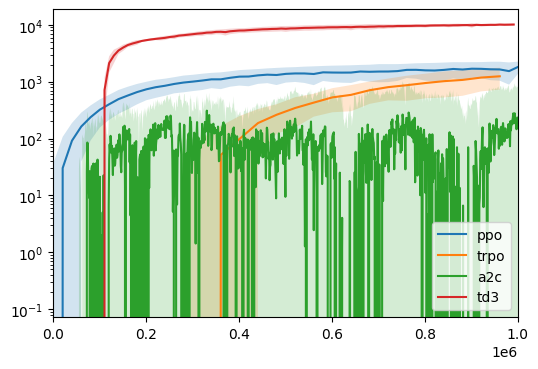

In [4]:
import matplotlib.pyplot as plt
import tikzplotlib
import pandas as pd 

def plot_score(results_dataframe, moving_avg_window=20, legend='ppo'):
    # Assuming your DataFrame is named 'df'
    # Use groupby to group the data by 'iteration' and 'timestep'
    grouped = results_dataframe.groupby(['timestep'])
    results_mean_std = grouped['reward'].agg(['mean', 'std'])

    results_mean_std.columns = results_mean_std.columns.map('_'.join).str.strip('_')
    results_mean_std.columns = results_mean_std.columns.str.replace('_', '')
    results_mean_std = results_mean_std.reset_index()

    # group the data by every 20 timestep
    grouped_data = results_mean_std.groupby(results_mean_std.index // moving_avg_window)

    # Define a dictionary of aggregation functions
    agg_dict = {'mean': 'mean', # Aggregate 'reward' column with mean
                'std': 'mean', # Aggregate 'std' column with mean
                'timestep': 'first', # Keep the last value of 'column2'
                # Add more columns as needed
            }

    # Apply the aggregation functions to each group and combine the results
    grouped_data = grouped_data.agg(agg_dict)
    
    # calculate the mean and std of each group
    timestep = grouped_data['timestep']
    mean_values = grouped_data['mean']
    std_values = grouped_data['std']

    # plot the mean line and shaded std area
    plt.plot(timestep,mean_values, label=legend)
    plt.fill_between(timestep, mean_values - std_values, mean_values + std_values, alpha=0.2)

def tikzplotlib_fix_ncols(obj):
    """
    workaround for matplotlib 3.6 renamed legend's _ncol to _ncols, which breaks tikzplotlib
    """
    if hasattr(obj, "_ncols"):
        obj._ncol = obj._ncols
    for child in obj.get_children():
        tikzplotlib_fix_ncols(child)

ppo_results=pd.read_csv(f'{CACHE_DIR}/ppo_training_10x1000000.csv')
trpo_results=pd.read_csv(f'{CACHE_DIR}/trpo_training.csv')
a2c_results=pd.read_csv(f'{CACHE_DIR}/a2c_training_10x1000000.csv')
td3_results=pd.read_csv(f'{CACHE_DIR}/td3_training_10x10000.csv')

fig = plt.figure(figsize=(6,4), dpi=100)
plot_score(ppo_results)
plot_score(trpo_results,moving_avg_window=40, legend='trpo')
plot_score(a2c_results,moving_avg_window=1, legend='a2c')
plot_score(td3_results,moving_avg_window=10, legend='td3')
plt.legend()
plt.xlim([0, 1e6])
plt.yscale('log')


tikzplotlib_fix_ncols(fig)
tikzplotlib.save("all_curves_halfcheetah.tex")
